In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import enchant
from sklearn.feature_extraction.text import CountVectorizer

# Dataset Preparation

In [2]:
true = pd.read_csv('../raw_data/True.csv')
fake = pd.read_csv('../raw_data/Fake.csv')

In [3]:
true.drop(columns = ['subject','date'], inplace = True)
fake.drop(columns = ['subject','date'], inplace = True)

In [4]:
true['score'] = 1
fake['score'] = 0

In [5]:
data = pd.concat([true,fake],ignore_index=True)
data.head()

,title,text,score
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


# Cleaning

In [6]:
def remove_punctuation(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

def remove_numbers(text):
    text = ''.join(word for word in text if not word.isdigit())
    return text

data['text']=data['text'].apply(remove_punctuation)
data['text']=data['text'].apply(remove_numbers)

In [7]:
def tokenize_text(text):
    return text.split()

data['tokens']=data['text'].apply(tokenize_text)

In [8]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))
data['tokens'] = data['tokens'].apply(lambda tokens: [token for token in tokens if token.lower() not in (stop_words)])

In [9]:
data['tokens'] 

0        [WASHINGTON, Reuters, head, conservative, Repu...
1        [WASHINGTON, Reuters, Transgender, people, all...
2        [WASHINGTON, Reuters, special, counsel, invest...
3        [WASHINGTON, Reuters, Trump, campaign, adviser...
4        [SEATTLEWASHINGTON, Reuters, President, Donald...
5        [WEST, PALM, BEACH, FlaWASHINGTON, Reuters, Wh...
6        [WEST, PALM, BEACH, Fla, Reuters, President, D...
7        [following, statements, posted, verified, Twit...
8        [following, statements, posted, verified, Twit...
9        [WASHINGTON, Reuters, Alabama, Secretary, Stat...
10       [Reuters, Alabama, officials, Thursday, certif...
11       [NEW, YORKWASHINGTON, Reuters, new, US, tax, c...
12       [following, statements, posted, verified, Twit...
13       [following, statements, posted, verified, Twit...
14       [Dec, story, second, paragraph, corrects, name...
15       [Reuters, lottery, drawing, settle, tied, Virg...
16       [WASHINGTON, Reuters, GeorgianAmerican, busine.

In [10]:
english = enchant.DictWithPWL("en_US", "vocab.txt")
wrong_words={}
correct_words=set()
def get_typos_t(tokens):
     wrong_count=0
     for token in tokens:
            if token in wrong_words:
                wrong_words[token]+=1
                wrong_count+=1
            else:
                if not token in correct_words:    
                    if not english.check(token) and not english.check(token.capitalize()):
                        wrong_words[token]=1
                        wrong_count+=1
                    else:
                        correct_words.add(token)
     return wrong_count       

# Keep Cleaning

In [11]:
data['token_count']=data['tokens'].apply(lambda tokens:len(tokens))

In [12]:
data['wrong_tokens_count']=data['tokens'].apply(get_typos_t)

In [13]:
data['typo_ratio']= data['wrong_tokens_count']/data['token_count']


<AxesSubplot:xlabel='score', ylabel='typo_ratio'>

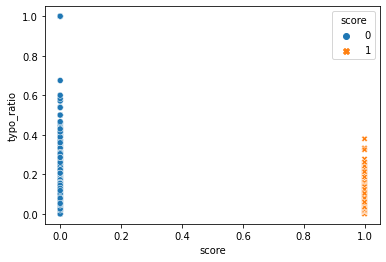

In [14]:
sns.scatterplot(data=data, x="score", y="typo_ratio", hue="score", style="score")

In [15]:
data.columns

Index(['title', 'text', 'score', 'tokens', 'token_count', 'wrong_tokens_count',
       'typo_ratio'],
      dtype='object')

In [16]:
data_clean = data[['title', 'text', 'typo_ratio','score']].copy()

In [17]:
data_clean.shape

(44898, 4)

# Log Regression

In [18]:
data_clean.head()

,title,text,typo_ratio,score
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON Reuters The head of a conservative...,0.062780,1
1,U.S. military to accept transgender recruits o...,WASHINGTON Reuters Transgender people will be...,0.055556,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON Reuters The special counsel invest...,0.041045,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON Reuters Trump campaign adviser Geo...,0.069869,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLEWASHINGTON Reuters President Donald Tr...,0.061224,1


In [19]:
#feature_cols = ['text', 'typo_ratio']
#x=data_clean[feature_cols]
y=data['score']

In [20]:
feature_cols = ['text','typo_ratio']

#x=data_clean[feature_cols]
x=data_clean[['text','typo_ratio']]

In [21]:
x.shape

(44898, 2)

In [22]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,test_size=0.3)

In [23]:
x_train

,text,typo_ratio
33958,This latest Wikileaks email is evidence of mor...,0.092391
19813,BERLIN Reuters Germany s Free Democrats FDP w...,0.117302
25814,Trump has been having a very very bad week Fir...,0.049020
18689,TALLINN Reuters French President Emmanuel Mac...,0.054670
44673,Do roses know their thorns can hurt a quot...,0.075447
22749,Earlier this month a sinkhole opened up outsid...,0.232687
2628,WASHINGTON Reuters The cofounder of the firm ...,0.090909
10117,WASHINGTON Reuters US Vice President Joe Bide...,0.066667
4388,BRUSSELS Reuters European Council President D...,0.050000
16056,TOKYO Reuters A tunnel at North Korea s nucle...,0.035714


In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
preprocessor = ColumnTransformer([
    ('vectorizer_text', CountVectorizer(), 'text'),

])
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('Logistic', LogisticRegression())])

In [25]:

# #from sklearn.feature_extraction.text import TfidfVectorizer

# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score

# vectorizer = CountVectorizer()
# #vectorizer_T = TfidfVectorizer()
# #x_vec = vectorizer.fit_transform(x_train)
# x_train_vec = vectorizer.fit_transform(x_train['text'])

In [26]:
final_pipe.fit(x_train,y_train)

/Users/andreamontagnoli/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('vectorizer_text', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', i...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [27]:
final_pipe.score(x_test,y_test)

0.9966592427616926

In [28]:
y_test.shape

(13470,)

In [29]:
# x_train_vec=pd.DataFrame(x_train_vec)
# #x_vec=x_train_vec+x_train['typo_ratio']

In [30]:
# x_vec=x_train_vec+x_train['typo_ratio']

In [31]:
# model=LogisticRegression()

In [32]:
# x_vec.shape

In [33]:
# print(x_vec)

In [34]:
# y_train.shape

In [35]:
# model.fit(x_vec,y_train)

In [36]:
pred=model.predict(vectorizer.transform(x_test))

NameError: name 'model' is not defined

In [ ]:
score=accuracy_score(y_test,pred)
score

# Word_tokenizer

In [ ]:
#data['tokens_tweet']= data['text'].apply(tknzr)

In [ ]:
from nltk.tokenize import word_tokenize
data['tokens_tweet']=data['text'].apply(word_tokenize)

In [ ]:
data.head()